In [1]:
import tensorflow as tf
import gym
import numpy as np 
import random
from collections import deque

In [2]:
num_of_episodes = 10000

In [3]:
class QNetwork(tf.keras.Model):
    
    def __init__(self):
        
        super().__init__()
        # Shared layers for policy and value function networks
        self.layer1 = tf.keras.layers.Dense(1024, activation = 'relu')
        self.layer2 = tf.keras.layers.Dense(512, activation = 'relu')
        self.out = tf.keras.layers.Dense(2, activation = None) # ... from state to action probabilities for pi
        
    def call(self, state):
        
        x = tf.convert_to_tensor(state)
        x = self.layer1(x)
        x = self.layer2(x)
        out = self.out(x)
        
        return out

In [4]:
class Agent():
    
    def __init__(self):
        self.gamma = 0.99
        self.eps_max = 1
        self.eps_min = 0.01
        self.decay_rate = 0.01 # number of episodes over which epsilon is decayed
        
        self.qModel = QNetwork()
        self.qopt = tf.keras.optimizers.Adam(learning_rate=1e-4)
        
    def choose_action(self, state, e):
        
        cond = random.random() # generate random float between 0 and 1
        
        eps = self.eps_min + (self.eps_max-self.eps_min)*np.exp(-self.decay_rate*e)
        
        if cond < eps:
            # Choose random action
            action = random.randint(0,1)
            
        else: # Choose greedy action
            Q_s = self.qModel(np.array([state]))
            action = tf.math.argmax(Q_s, axis=1)
            action = action.numpy()[0]
            
        return action
    
    def train(self, buffer): # train from buffer
        
        with tf.GradientTape() as tape:
            
            error_store = [] # store errors from batch
            
            for state, action, reward, next_state, done in buffer:

                state = np.array([state])
                next_state = np.array([next_state])

                # Get prediction
                a =  action # action chosen to calculate Q(s,a)
                Q_s = self.qModel(state, training=True) # select the value of the Q value associated with pair s,a
                Q_s_a = Q_s[0][a]

                # Get target
                Q_sp = self.qModel(next_state, training=True)
                max_Q = tf.reduce_max(Q_sp, axis=1)
                target = reward + self.gamma*max_Q

                # Compute error
                sample_error = (target - Q_s_a)**2

                error_store.append(sample_error)
                    
            batch_error = tf.math.add_n(error_store)

        grads = tape.gradient(batch_error, self.qModel.trainable_variables)    
        self.qopt.apply_gradients(zip(grads, self.qModel.trainable_variables))
            

In [5]:
agent = Agent()
env = gym.make("CartPole-v1")
cum_rew_train = []

In [6]:
"""
 ---------------
# TRAINING CELL #
 --------------- 
"""

def main():
    
    # Create a summary writer for TensorBoard
    writer = tf.summary.create_file_writer("logs/")
    
    for e in range(num_of_episodes):
        
        obs, info = env.reset()
        done = False
        score = 0
        buffer = []
        
        while not done:
            
            action = agent.choose_action(obs, e)
            
            next_obs, reward, terminated, truncated, info = env.step(action)
            
            score += reward
            done = terminated or truncated
            
            buffer.append((obs, action, reward, next_obs, done))
            
            if done:
                agent.train(buffer)
            
            obs = next_obs
            
        cum_rew_train.append(score)
        print(f"Episode {e} score is {score}")
        
        # Tensorboard log stuff
#         with writer.as_default():
#             tf.summary.scalar(name="cumulative_reward", data=score, step=e)
#             dqn_variables = agent.qModel.trainable_variables
#             for i, var in enumerate(dqn_variables):
#                 tf.summary.histogram(name=f"dqn_variable_{i}", data=var, step=e)
#                 if len(var.shape) == 2:
#                     # Log the weights of each layer
#                     kernel = var[:, :]
#                     tf.summary.histogram(name=f"layer_{i}_weights", data=kernel, step=e)
#             writer.flush()
        
main()

Episode 0 score is 13.0
Episode 1 score is 27.0
Episode 2 score is 27.0
Episode 3 score is 23.0
Episode 4 score is 14.0
Episode 5 score is 22.0
Episode 6 score is 25.0
Episode 7 score is 15.0
Episode 8 score is 28.0
Episode 9 score is 23.0
Episode 10 score is 15.0
Episode 11 score is 18.0
Episode 12 score is 28.0
Episode 13 score is 27.0
Episode 14 score is 23.0
Episode 15 score is 15.0
Episode 16 score is 9.0
Episode 17 score is 38.0
Episode 18 score is 28.0
Episode 19 score is 12.0
Episode 20 score is 16.0
Episode 21 score is 18.0
Episode 22 score is 25.0
Episode 23 score is 18.0
Episode 24 score is 23.0
Episode 25 score is 34.0
Episode 26 score is 41.0
Episode 27 score is 33.0
Episode 28 score is 18.0
Episode 29 score is 14.0
Episode 30 score is 18.0
Episode 31 score is 15.0
Episode 32 score is 20.0
Episode 33 score is 16.0
Episode 34 score is 23.0
Episode 35 score is 51.0
Episode 36 score is 21.0
Episode 37 score is 22.0
Episode 38 score is 18.0
Episode 39 score is 26.0
Episode 40 

Episode 318 score is 8.0
Episode 319 score is 9.0
Episode 320 score is 11.0
Episode 321 score is 13.0
Episode 322 score is 14.0
Episode 323 score is 10.0
Episode 324 score is 12.0
Episode 325 score is 10.0
Episode 326 score is 12.0
Episode 327 score is 8.0
Episode 328 score is 9.0
Episode 329 score is 10.0
Episode 330 score is 9.0
Episode 331 score is 12.0
Episode 332 score is 13.0
Episode 333 score is 58.0
Episode 334 score is 96.0
Episode 335 score is 88.0
Episode 336 score is 152.0
Episode 337 score is 315.0
Episode 338 score is 491.0
Episode 339 score is 83.0
Episode 340 score is 89.0
Episode 341 score is 76.0
Episode 342 score is 59.0
Episode 343 score is 48.0
Episode 344 score is 29.0
Episode 345 score is 31.0
Episode 346 score is 16.0
Episode 347 score is 18.0
Episode 348 score is 21.0
Episode 349 score is 18.0
Episode 350 score is 17.0
Episode 351 score is 13.0
Episode 352 score is 14.0
Episode 353 score is 13.0
Episode 354 score is 13.0
Episode 355 score is 14.0
Episode 356 sc

Episode 629 score is 44.0
Episode 630 score is 47.0
Episode 631 score is 45.0
Episode 632 score is 16.0
Episode 633 score is 47.0
Episode 634 score is 16.0
Episode 635 score is 44.0
Episode 636 score is 47.0
Episode 637 score is 46.0
Episode 638 score is 48.0
Episode 639 score is 45.0
Episode 640 score is 45.0
Episode 641 score is 50.0
Episode 642 score is 48.0
Episode 643 score is 44.0
Episode 644 score is 45.0
Episode 645 score is 45.0
Episode 646 score is 44.0
Episode 647 score is 41.0
Episode 648 score is 45.0
Episode 649 score is 46.0
Episode 650 score is 46.0
Episode 651 score is 17.0
Episode 652 score is 48.0
Episode 653 score is 45.0
Episode 654 score is 48.0
Episode 655 score is 46.0
Episode 656 score is 50.0
Episode 657 score is 17.0
Episode 658 score is 50.0
Episode 659 score is 54.0
Episode 660 score is 56.0
Episode 661 score is 56.0
Episode 662 score is 56.0
Episode 663 score is 56.0
Episode 664 score is 18.0
Episode 665 score is 14.0
Episode 666 score is 66.0
Episode 667 

Episode 945 score is 12.0
Episode 946 score is 11.0
Episode 947 score is 11.0
Episode 948 score is 12.0
Episode 949 score is 84.0
Episode 950 score is 9.0
Episode 951 score is 77.0
Episode 952 score is 10.0
Episode 953 score is 11.0
Episode 954 score is 8.0
Episode 955 score is 10.0
Episode 956 score is 12.0
Episode 957 score is 12.0
Episode 958 score is 10.0
Episode 959 score is 11.0
Episode 960 score is 10.0
Episode 961 score is 11.0
Episode 962 score is 11.0
Episode 963 score is 9.0
Episode 964 score is 10.0
Episode 965 score is 10.0
Episode 966 score is 11.0
Episode 967 score is 11.0
Episode 968 score is 9.0
Episode 969 score is 10.0
Episode 970 score is 12.0
Episode 971 score is 10.0
Episode 972 score is 9.0
Episode 973 score is 11.0
Episode 974 score is 10.0
Episode 975 score is 11.0
Episode 976 score is 10.0
Episode 977 score is 9.0
Episode 978 score is 10.0
Episode 979 score is 11.0
Episode 980 score is 11.0
Episode 981 score is 10.0
Episode 982 score is 9.0
Episode 983 score i

Episode 1253 score is 63.0
Episode 1254 score is 24.0
Episode 1255 score is 23.0
Episode 1256 score is 24.0
Episode 1257 score is 24.0
Episode 1258 score is 25.0
Episode 1259 score is 21.0
Episode 1260 score is 18.0
Episode 1261 score is 21.0
Episode 1262 score is 20.0
Episode 1263 score is 22.0
Episode 1264 score is 21.0
Episode 1265 score is 20.0
Episode 1266 score is 25.0
Episode 1267 score is 23.0
Episode 1268 score is 22.0
Episode 1269 score is 22.0
Episode 1270 score is 22.0
Episode 1271 score is 26.0
Episode 1272 score is 25.0
Episode 1273 score is 25.0
Episode 1274 score is 23.0
Episode 1275 score is 24.0
Episode 1276 score is 22.0
Episode 1277 score is 21.0
Episode 1278 score is 18.0
Episode 1279 score is 24.0
Episode 1280 score is 24.0
Episode 1281 score is 23.0
Episode 1282 score is 23.0
Episode 1283 score is 23.0
Episode 1284 score is 12.0
Episode 1285 score is 22.0
Episode 1286 score is 22.0
Episode 1287 score is 10.0
Episode 1288 score is 10.0
Episode 1289 score is 25.0
E

Episode 1555 score is 12.0
Episode 1556 score is 145.0
Episode 1557 score is 10.0
Episode 1558 score is 12.0
Episode 1559 score is 12.0
Episode 1560 score is 12.0
Episode 1561 score is 9.0
Episode 1562 score is 11.0
Episode 1563 score is 12.0
Episode 1564 score is 158.0
Episode 1565 score is 11.0
Episode 1566 score is 11.0
Episode 1567 score is 11.0
Episode 1568 score is 10.0
Episode 1569 score is 12.0
Episode 1570 score is 146.0
Episode 1571 score is 12.0
Episode 1572 score is 11.0
Episode 1573 score is 10.0
Episode 1574 score is 11.0
Episode 1575 score is 11.0
Episode 1576 score is 151.0
Episode 1577 score is 11.0
Episode 1578 score is 11.0
Episode 1579 score is 9.0
Episode 1580 score is 10.0
Episode 1581 score is 9.0
Episode 1582 score is 12.0
Episode 1583 score is 10.0
Episode 1584 score is 12.0
Episode 1585 score is 9.0
Episode 1586 score is 153.0
Episode 1587 score is 11.0
Episode 1588 score is 11.0
Episode 1589 score is 11.0
Episode 1590 score is 12.0
Episode 1591 score is 11.0


Episode 1860 score is 12.0
Episode 1861 score is 159.0
Episode 1862 score is 10.0
Episode 1863 score is 157.0
Episode 1864 score is 12.0
Episode 1865 score is 11.0
Episode 1866 score is 13.0
Episode 1867 score is 12.0
Episode 1868 score is 15.0
Episode 1869 score is 176.0
Episode 1870 score is 13.0
Episode 1871 score is 12.0
Episode 1872 score is 11.0
Episode 1873 score is 185.0
Episode 1874 score is 184.0
Episode 1875 score is 181.0
Episode 1876 score is 14.0
Episode 1877 score is 170.0
Episode 1878 score is 15.0
Episode 1879 score is 9.0
Episode 1880 score is 12.0
Episode 1881 score is 13.0
Episode 1882 score is 16.0
Episode 1883 score is 10.0
Episode 1884 score is 10.0
Episode 1885 score is 11.0
Episode 1886 score is 166.0
Episode 1887 score is 9.0
Episode 1888 score is 11.0
Episode 1889 score is 11.0
Episode 1890 score is 10.0
Episode 1891 score is 10.0
Episode 1892 score is 11.0
Episode 1893 score is 169.0
Episode 1894 score is 11.0
Episode 1895 score is 9.0
Episode 1896 score is 

Episode 2166 score is 10.0
Episode 2167 score is 9.0
Episode 2168 score is 9.0
Episode 2169 score is 10.0
Episode 2170 score is 9.0
Episode 2171 score is 9.0
Episode 2172 score is 10.0
Episode 2173 score is 12.0
Episode 2174 score is 10.0
Episode 2175 score is 8.0
Episode 2176 score is 9.0
Episode 2177 score is 9.0
Episode 2178 score is 10.0
Episode 2179 score is 9.0
Episode 2180 score is 9.0
Episode 2181 score is 10.0
Episode 2182 score is 9.0
Episode 2183 score is 9.0
Episode 2184 score is 9.0
Episode 2185 score is 10.0
Episode 2186 score is 10.0
Episode 2187 score is 10.0
Episode 2188 score is 9.0
Episode 2189 score is 10.0
Episode 2190 score is 8.0
Episode 2191 score is 10.0
Episode 2192 score is 8.0
Episode 2193 score is 8.0
Episode 2194 score is 10.0
Episode 2195 score is 10.0
Episode 2196 score is 9.0
Episode 2197 score is 8.0
Episode 2198 score is 10.0
Episode 2199 score is 11.0
Episode 2200 score is 10.0
Episode 2201 score is 10.0
Episode 2202 score is 10.0
Episode 2203 score 

Episode 2478 score is 10.0
Episode 2479 score is 10.0
Episode 2480 score is 10.0
Episode 2481 score is 12.0
Episode 2482 score is 10.0
Episode 2483 score is 10.0
Episode 2484 score is 9.0
Episode 2485 score is 10.0
Episode 2486 score is 9.0
Episode 2487 score is 10.0
Episode 2488 score is 10.0
Episode 2489 score is 10.0
Episode 2490 score is 9.0
Episode 2491 score is 9.0
Episode 2492 score is 9.0
Episode 2493 score is 13.0
Episode 2494 score is 10.0
Episode 2495 score is 9.0
Episode 2496 score is 10.0
Episode 2497 score is 10.0
Episode 2498 score is 10.0
Episode 2499 score is 9.0
Episode 2500 score is 10.0
Episode 2501 score is 11.0
Episode 2502 score is 11.0
Episode 2503 score is 10.0
Episode 2504 score is 9.0
Episode 2505 score is 9.0
Episode 2506 score is 10.0
Episode 2507 score is 10.0
Episode 2508 score is 10.0
Episode 2509 score is 8.0
Episode 2510 score is 10.0
Episode 2511 score is 10.0
Episode 2512 score is 8.0
Episode 2513 score is 9.0
Episode 2514 score is 11.0
Episode 2515 

Episode 2788 score is 10.0
Episode 2789 score is 10.0
Episode 2790 score is 10.0
Episode 2791 score is 10.0
Episode 2792 score is 9.0
Episode 2793 score is 10.0
Episode 2794 score is 10.0
Episode 2795 score is 9.0
Episode 2796 score is 9.0
Episode 2797 score is 11.0
Episode 2798 score is 10.0
Episode 2799 score is 8.0
Episode 2800 score is 9.0
Episode 2801 score is 9.0
Episode 2802 score is 9.0
Episode 2803 score is 10.0
Episode 2804 score is 10.0
Episode 2805 score is 11.0
Episode 2806 score is 14.0
Episode 2807 score is 10.0
Episode 2808 score is 10.0
Episode 2809 score is 9.0
Episode 2810 score is 10.0
Episode 2811 score is 10.0
Episode 2812 score is 9.0
Episode 2813 score is 10.0
Episode 2814 score is 10.0
Episode 2815 score is 9.0
Episode 2816 score is 9.0
Episode 2817 score is 10.0
Episode 2818 score is 9.0
Episode 2819 score is 9.0
Episode 2820 score is 9.0
Episode 2821 score is 10.0
Episode 2822 score is 9.0
Episode 2823 score is 10.0
Episode 2824 score is 11.0
Episode 2825 sco

Episode 3099 score is 10.0
Episode 3100 score is 10.0
Episode 3101 score is 9.0
Episode 3102 score is 10.0
Episode 3103 score is 9.0
Episode 3104 score is 9.0
Episode 3105 score is 10.0
Episode 3106 score is 8.0
Episode 3107 score is 9.0
Episode 3108 score is 10.0
Episode 3109 score is 9.0
Episode 3110 score is 8.0
Episode 3111 score is 9.0
Episode 3112 score is 9.0
Episode 3113 score is 10.0
Episode 3114 score is 10.0
Episode 3115 score is 11.0
Episode 3116 score is 10.0
Episode 3117 score is 10.0
Episode 3118 score is 10.0
Episode 3119 score is 8.0
Episode 3120 score is 10.0
Episode 3121 score is 10.0
Episode 3122 score is 9.0
Episode 3123 score is 9.0
Episode 3124 score is 10.0
Episode 3125 score is 10.0
Episode 3126 score is 10.0
Episode 3127 score is 10.0
Episode 3128 score is 10.0
Episode 3129 score is 9.0
Episode 3130 score is 10.0
Episode 3131 score is 9.0
Episode 3132 score is 11.0
Episode 3133 score is 9.0
Episode 3134 score is 10.0
Episode 3135 score is 10.0
Episode 3136 sco

Episode 3409 score is 9.0
Episode 3410 score is 9.0
Episode 3411 score is 10.0
Episode 3412 score is 9.0
Episode 3413 score is 9.0
Episode 3414 score is 11.0
Episode 3415 score is 10.0
Episode 3416 score is 10.0
Episode 3417 score is 11.0
Episode 3418 score is 10.0
Episode 3419 score is 10.0
Episode 3420 score is 9.0
Episode 3421 score is 10.0
Episode 3422 score is 9.0
Episode 3423 score is 10.0
Episode 3424 score is 9.0
Episode 3425 score is 9.0
Episode 3426 score is 9.0
Episode 3427 score is 10.0
Episode 3428 score is 10.0
Episode 3429 score is 10.0
Episode 3430 score is 9.0
Episode 3431 score is 9.0
Episode 3432 score is 10.0
Episode 3433 score is 10.0
Episode 3434 score is 10.0
Episode 3435 score is 8.0
Episode 3436 score is 8.0
Episode 3437 score is 11.0
Episode 3438 score is 9.0
Episode 3439 score is 10.0
Episode 3440 score is 11.0
Episode 3441 score is 9.0
Episode 3442 score is 10.0
Episode 3443 score is 10.0
Episode 3444 score is 9.0
Episode 3445 score is 10.0
Episode 3446 scor

Episode 3713 score is 500.0
Episode 3714 score is 500.0
Episode 3715 score is 500.0
Episode 3716 score is 500.0
Episode 3717 score is 500.0
Episode 3718 score is 500.0
Episode 3719 score is 500.0
Episode 3720 score is 500.0
Episode 3721 score is 500.0
Episode 3722 score is 500.0
Episode 3723 score is 500.0
Episode 3724 score is 500.0
Episode 3725 score is 500.0
Episode 3726 score is 500.0
Episode 3727 score is 500.0
Episode 3728 score is 500.0
Episode 3729 score is 500.0
Episode 3730 score is 500.0
Episode 3731 score is 500.0
Episode 3732 score is 500.0
Episode 3733 score is 137.0
Episode 3734 score is 500.0
Episode 3735 score is 500.0
Episode 3736 score is 500.0
Episode 3737 score is 500.0
Episode 3738 score is 500.0
Episode 3739 score is 500.0
Episode 3740 score is 37.0
Episode 3741 score is 500.0
Episode 3742 score is 500.0
Episode 3743 score is 500.0
Episode 3744 score is 500.0
Episode 3745 score is 500.0
Episode 3746 score is 500.0
Episode 3747 score is 500.0
Episode 3748 score is

Episode 4021 score is 10.0
Episode 4022 score is 9.0
Episode 4023 score is 9.0
Episode 4024 score is 10.0
Episode 4025 score is 10.0
Episode 4026 score is 9.0
Episode 4027 score is 12.0
Episode 4028 score is 9.0
Episode 4029 score is 10.0
Episode 4030 score is 9.0
Episode 4031 score is 9.0
Episode 4032 score is 9.0
Episode 4033 score is 9.0
Episode 4034 score is 8.0
Episode 4035 score is 8.0
Episode 4036 score is 9.0
Episode 4037 score is 9.0
Episode 4038 score is 10.0
Episode 4039 score is 9.0
Episode 4040 score is 10.0
Episode 4041 score is 10.0
Episode 4042 score is 9.0
Episode 4043 score is 9.0
Episode 4044 score is 10.0
Episode 4045 score is 10.0
Episode 4046 score is 9.0
Episode 4047 score is 10.0
Episode 4048 score is 9.0
Episode 4049 score is 8.0
Episode 4050 score is 10.0
Episode 4051 score is 10.0
Episode 4052 score is 9.0
Episode 4053 score is 10.0
Episode 4054 score is 9.0
Episode 4055 score is 9.0
Episode 4056 score is 10.0
Episode 4057 score is 9.0
Episode 4058 score is 8

Episode 4333 score is 9.0
Episode 4334 score is 9.0
Episode 4335 score is 9.0
Episode 4336 score is 11.0
Episode 4337 score is 9.0
Episode 4338 score is 10.0
Episode 4339 score is 9.0
Episode 4340 score is 10.0
Episode 4341 score is 10.0
Episode 4342 score is 9.0
Episode 4343 score is 10.0
Episode 4344 score is 10.0
Episode 4345 score is 10.0
Episode 4346 score is 10.0
Episode 4347 score is 10.0
Episode 4348 score is 9.0
Episode 4349 score is 9.0
Episode 4350 score is 10.0
Episode 4351 score is 10.0
Episode 4352 score is 9.0
Episode 4353 score is 8.0
Episode 4354 score is 9.0
Episode 4355 score is 9.0
Episode 4356 score is 10.0
Episode 4357 score is 10.0
Episode 4358 score is 9.0
Episode 4359 score is 8.0
Episode 4360 score is 10.0
Episode 4361 score is 9.0
Episode 4362 score is 10.0
Episode 4363 score is 10.0
Episode 4364 score is 11.0
Episode 4365 score is 8.0
Episode 4366 score is 9.0
Episode 4367 score is 9.0
Episode 4368 score is 8.0
Episode 4369 score is 10.0
Episode 4370 score i

Episode 4643 score is 10.0
Episode 4644 score is 10.0
Episode 4645 score is 10.0
Episode 4646 score is 10.0
Episode 4647 score is 9.0
Episode 4648 score is 8.0
Episode 4649 score is 8.0
Episode 4650 score is 8.0
Episode 4651 score is 9.0
Episode 4652 score is 10.0
Episode 4653 score is 9.0
Episode 4654 score is 10.0
Episode 4655 score is 10.0
Episode 4656 score is 8.0
Episode 4657 score is 9.0
Episode 4658 score is 9.0
Episode 4659 score is 10.0
Episode 4660 score is 10.0
Episode 4661 score is 10.0
Episode 4662 score is 10.0
Episode 4663 score is 9.0
Episode 4664 score is 11.0
Episode 4665 score is 10.0
Episode 4666 score is 10.0
Episode 4667 score is 10.0
Episode 4668 score is 9.0
Episode 4669 score is 9.0
Episode 4670 score is 9.0
Episode 4671 score is 9.0
Episode 4672 score is 8.0
Episode 4673 score is 10.0
Episode 4674 score is 10.0
Episode 4675 score is 9.0
Episode 4676 score is 9.0
Episode 4677 score is 9.0
Episode 4678 score is 9.0
Episode 4679 score is 8.0
Episode 4680 score is

Episode 4954 score is 10.0
Episode 4955 score is 9.0
Episode 4956 score is 9.0
Episode 4957 score is 10.0
Episode 4958 score is 10.0
Episode 4959 score is 10.0
Episode 4960 score is 10.0
Episode 4961 score is 10.0
Episode 4962 score is 8.0
Episode 4963 score is 8.0
Episode 4964 score is 9.0
Episode 4965 score is 9.0
Episode 4966 score is 9.0
Episode 4967 score is 9.0
Episode 4968 score is 10.0
Episode 4969 score is 9.0
Episode 4970 score is 10.0
Episode 4971 score is 10.0
Episode 4972 score is 10.0
Episode 4973 score is 8.0
Episode 4974 score is 9.0
Episode 4975 score is 10.0
Episode 4976 score is 9.0
Episode 4977 score is 10.0
Episode 4978 score is 9.0
Episode 4979 score is 10.0
Episode 4980 score is 10.0
Episode 4981 score is 10.0
Episode 4982 score is 10.0
Episode 4983 score is 10.0
Episode 4984 score is 10.0
Episode 4985 score is 9.0
Episode 4986 score is 9.0
Episode 4987 score is 9.0
Episode 4988 score is 9.0
Episode 4989 score is 9.0
Episode 4990 score is 10.0
Episode 4991 score 

Episode 5265 score is 9.0
Episode 5266 score is 9.0
Episode 5267 score is 10.0
Episode 5268 score is 10.0
Episode 5269 score is 9.0
Episode 5270 score is 10.0
Episode 5271 score is 9.0
Episode 5272 score is 11.0
Episode 5273 score is 10.0
Episode 5274 score is 9.0
Episode 5275 score is 9.0
Episode 5276 score is 8.0
Episode 5277 score is 10.0
Episode 5278 score is 10.0
Episode 5279 score is 9.0
Episode 5280 score is 9.0
Episode 5281 score is 10.0
Episode 5282 score is 8.0
Episode 5283 score is 9.0
Episode 5284 score is 8.0
Episode 5285 score is 10.0
Episode 5286 score is 10.0
Episode 5287 score is 10.0
Episode 5288 score is 9.0
Episode 5289 score is 9.0
Episode 5290 score is 9.0
Episode 5291 score is 10.0
Episode 5292 score is 10.0
Episode 5293 score is 9.0
Episode 5294 score is 8.0
Episode 5295 score is 9.0
Episode 5296 score is 9.0
Episode 5297 score is 9.0
Episode 5298 score is 9.0
Episode 5299 score is 10.0
Episode 5300 score is 8.0
Episode 5301 score is 11.0
Episode 5302 score is 1

Episode 5576 score is 9.0
Episode 5577 score is 8.0
Episode 5578 score is 10.0
Episode 5579 score is 9.0
Episode 5580 score is 9.0
Episode 5581 score is 8.0
Episode 5582 score is 10.0
Episode 5583 score is 9.0
Episode 5584 score is 10.0
Episode 5585 score is 10.0
Episode 5586 score is 10.0
Episode 5587 score is 10.0
Episode 5588 score is 9.0
Episode 5589 score is 9.0
Episode 5590 score is 10.0
Episode 5591 score is 8.0
Episode 5592 score is 9.0
Episode 5593 score is 10.0
Episode 5594 score is 10.0
Episode 5595 score is 10.0
Episode 5596 score is 8.0
Episode 5597 score is 10.0
Episode 5598 score is 9.0
Episode 5599 score is 9.0
Episode 5600 score is 10.0
Episode 5601 score is 10.0
Episode 5602 score is 9.0
Episode 5603 score is 10.0
Episode 5604 score is 10.0
Episode 5605 score is 8.0
Episode 5606 score is 8.0
Episode 5607 score is 10.0
Episode 5608 score is 9.0
Episode 5609 score is 10.0
Episode 5610 score is 10.0
Episode 5611 score is 9.0
Episode 5612 score is 9.0
Episode 5613 score i

Episode 5886 score is 9.0
Episode 5887 score is 9.0
Episode 5888 score is 10.0
Episode 5889 score is 9.0
Episode 5890 score is 10.0
Episode 5891 score is 9.0
Episode 5892 score is 9.0
Episode 5893 score is 8.0
Episode 5894 score is 10.0
Episode 5895 score is 9.0
Episode 5896 score is 10.0
Episode 5897 score is 9.0
Episode 5898 score is 8.0
Episode 5899 score is 9.0
Episode 5900 score is 10.0
Episode 5901 score is 9.0
Episode 5902 score is 9.0
Episode 5903 score is 10.0
Episode 5904 score is 10.0
Episode 5905 score is 9.0
Episode 5906 score is 8.0
Episode 5907 score is 10.0
Episode 5908 score is 10.0
Episode 5909 score is 9.0
Episode 5910 score is 9.0
Episode 5911 score is 9.0
Episode 5912 score is 8.0
Episode 5913 score is 10.0
Episode 5914 score is 9.0
Episode 5915 score is 10.0
Episode 5916 score is 10.0
Episode 5917 score is 9.0
Episode 5918 score is 8.0
Episode 5919 score is 9.0
Episode 5920 score is 10.0
Episode 5921 score is 9.0
Episode 5922 score is 9.0
Episode 5923 score is 9.0

Episode 6196 score is 14.0
Episode 6197 score is 500.0
Episode 6198 score is 500.0
Episode 6199 score is 500.0
Episode 6200 score is 15.0
Episode 6201 score is 500.0
Episode 6202 score is 500.0
Episode 6203 score is 500.0
Episode 6204 score is 500.0
Episode 6205 score is 13.0
Episode 6206 score is 11.0
Episode 6207 score is 12.0
Episode 6208 score is 29.0
Episode 6209 score is 9.0
Episode 6210 score is 13.0
Episode 6211 score is 11.0
Episode 6212 score is 11.0
Episode 6213 score is 26.0
Episode 6214 score is 11.0
Episode 6215 score is 9.0
Episode 6216 score is 9.0
Episode 6217 score is 10.0
Episode 6218 score is 11.0
Episode 6219 score is 9.0
Episode 6220 score is 10.0
Episode 6221 score is 9.0
Episode 6222 score is 9.0
Episode 6223 score is 9.0
Episode 6224 score is 10.0
Episode 6225 score is 10.0
Episode 6226 score is 8.0
Episode 6227 score is 9.0
Episode 6228 score is 10.0
Episode 6229 score is 10.0
Episode 6230 score is 10.0
Episode 6231 score is 9.0
Episode 6232 score is 10.0
Epis

Episode 6506 score is 8.0
Episode 6507 score is 9.0
Episode 6508 score is 10.0
Episode 6509 score is 8.0
Episode 6510 score is 10.0
Episode 6511 score is 10.0
Episode 6512 score is 10.0
Episode 6513 score is 10.0
Episode 6514 score is 9.0
Episode 6515 score is 10.0
Episode 6516 score is 8.0
Episode 6517 score is 8.0
Episode 6518 score is 10.0
Episode 6519 score is 9.0
Episode 6520 score is 10.0
Episode 6521 score is 10.0
Episode 6522 score is 11.0
Episode 6523 score is 9.0
Episode 6524 score is 9.0
Episode 6525 score is 9.0
Episode 6526 score is 8.0
Episode 6527 score is 9.0
Episode 6528 score is 8.0
Episode 6529 score is 10.0
Episode 6530 score is 10.0
Episode 6531 score is 9.0
Episode 6532 score is 9.0
Episode 6533 score is 9.0
Episode 6534 score is 10.0
Episode 6535 score is 10.0
Episode 6536 score is 8.0
Episode 6537 score is 8.0
Episode 6538 score is 9.0
Episode 6539 score is 9.0
Episode 6540 score is 9.0
Episode 6541 score is 9.0
Episode 6542 score is 8.0
Episode 6543 score is 9.

Episode 6817 score is 11.0
Episode 6818 score is 9.0
Episode 6819 score is 9.0
Episode 6820 score is 10.0
Episode 6821 score is 9.0
Episode 6822 score is 8.0
Episode 6823 score is 9.0
Episode 6824 score is 9.0
Episode 6825 score is 10.0
Episode 6826 score is 10.0
Episode 6827 score is 8.0
Episode 6828 score is 10.0
Episode 6829 score is 10.0
Episode 6830 score is 9.0
Episode 6831 score is 10.0
Episode 6832 score is 10.0
Episode 6833 score is 9.0
Episode 6834 score is 10.0
Episode 6835 score is 9.0
Episode 6836 score is 9.0
Episode 6837 score is 10.0
Episode 6838 score is 9.0
Episode 6839 score is 9.0
Episode 6840 score is 10.0
Episode 6841 score is 10.0
Episode 6842 score is 9.0
Episode 6843 score is 10.0
Episode 6844 score is 10.0
Episode 6845 score is 10.0
Episode 6846 score is 11.0
Episode 6847 score is 8.0
Episode 6848 score is 10.0
Episode 6849 score is 9.0
Episode 6850 score is 10.0
Episode 6851 score is 9.0
Episode 6852 score is 10.0
Episode 6853 score is 10.0
Episode 6854 score

Episode 7126 score is 10.0
Episode 7127 score is 11.0
Episode 7128 score is 9.0
Episode 7129 score is 9.0
Episode 7130 score is 8.0
Episode 7131 score is 10.0
Episode 7132 score is 9.0
Episode 7133 score is 10.0
Episode 7134 score is 9.0
Episode 7135 score is 10.0
Episode 7136 score is 10.0
Episode 7137 score is 9.0
Episode 7138 score is 9.0
Episode 7139 score is 9.0
Episode 7140 score is 9.0
Episode 7141 score is 8.0
Episode 7142 score is 10.0
Episode 7143 score is 9.0
Episode 7144 score is 8.0
Episode 7145 score is 9.0
Episode 7146 score is 9.0
Episode 7147 score is 10.0
Episode 7148 score is 10.0
Episode 7149 score is 10.0
Episode 7150 score is 8.0
Episode 7151 score is 11.0
Episode 7152 score is 10.0
Episode 7153 score is 10.0
Episode 7154 score is 10.0
Episode 7155 score is 10.0
Episode 7156 score is 9.0
Episode 7157 score is 9.0
Episode 7158 score is 8.0
Episode 7159 score is 9.0
Episode 7160 score is 10.0
Episode 7161 score is 9.0
Episode 7162 score is 10.0
Episode 7163 score is

Episode 7437 score is 10.0
Episode 7438 score is 10.0
Episode 7439 score is 9.0
Episode 7440 score is 9.0
Episode 7441 score is 10.0
Episode 7442 score is 8.0
Episode 7443 score is 8.0
Episode 7444 score is 9.0
Episode 7445 score is 9.0
Episode 7446 score is 9.0
Episode 7447 score is 9.0
Episode 7448 score is 9.0
Episode 7449 score is 10.0
Episode 7450 score is 9.0
Episode 7451 score is 9.0
Episode 7452 score is 9.0
Episode 7453 score is 8.0
Episode 7454 score is 10.0
Episode 7455 score is 10.0
Episode 7456 score is 9.0
Episode 7457 score is 9.0
Episode 7458 score is 10.0
Episode 7459 score is 9.0
Episode 7460 score is 9.0
Episode 7461 score is 11.0
Episode 7462 score is 10.0
Episode 7463 score is 9.0
Episode 7464 score is 9.0
Episode 7465 score is 8.0
Episode 7466 score is 8.0
Episode 7467 score is 10.0
Episode 7468 score is 9.0
Episode 7469 score is 9.0
Episode 7470 score is 8.0
Episode 7471 score is 9.0
Episode 7472 score is 10.0
Episode 7473 score is 10.0
Episode 7474 score is 9.0


Episode 7748 score is 10.0
Episode 7749 score is 9.0
Episode 7750 score is 9.0
Episode 7751 score is 10.0
Episode 7752 score is 10.0
Episode 7753 score is 9.0
Episode 7754 score is 9.0
Episode 7755 score is 10.0
Episode 7756 score is 10.0
Episode 7757 score is 10.0
Episode 7758 score is 10.0
Episode 7759 score is 9.0
Episode 7760 score is 11.0
Episode 7761 score is 10.0
Episode 7762 score is 8.0
Episode 7763 score is 10.0
Episode 7764 score is 8.0
Episode 7765 score is 9.0
Episode 7766 score is 9.0
Episode 7767 score is 11.0
Episode 7768 score is 8.0
Episode 7769 score is 10.0
Episode 7770 score is 10.0
Episode 7771 score is 10.0
Episode 7772 score is 9.0
Episode 7773 score is 10.0
Episode 7774 score is 10.0
Episode 7775 score is 9.0
Episode 7776 score is 8.0
Episode 7777 score is 10.0
Episode 7778 score is 9.0
Episode 7779 score is 10.0
Episode 7780 score is 9.0
Episode 7781 score is 9.0
Episode 7782 score is 10.0
Episode 7783 score is 9.0
Episode 7784 score is 10.0
Episode 7785 score

Episode 8055 score is 10.0
Episode 8056 score is 9.0
Episode 8057 score is 11.0
Episode 8058 score is 9.0
Episode 8059 score is 10.0
Episode 8060 score is 9.0
Episode 8061 score is 9.0
Episode 8062 score is 10.0
Episode 8063 score is 9.0
Episode 8064 score is 11.0
Episode 8065 score is 10.0
Episode 8066 score is 10.0
Episode 8067 score is 10.0
Episode 8068 score is 9.0
Episode 8069 score is 10.0
Episode 8070 score is 10.0
Episode 8071 score is 10.0
Episode 8072 score is 10.0
Episode 8073 score is 9.0
Episode 8074 score is 9.0
Episode 8075 score is 10.0
Episode 8076 score is 10.0
Episode 8077 score is 10.0
Episode 8078 score is 10.0
Episode 8079 score is 10.0
Episode 8080 score is 11.0
Episode 8081 score is 9.0
Episode 8082 score is 10.0
Episode 8083 score is 9.0
Episode 8084 score is 12.0
Episode 8085 score is 10.0
Episode 8086 score is 11.0
Episode 8087 score is 10.0
Episode 8088 score is 9.0
Episode 8089 score is 9.0
Episode 8090 score is 10.0
Episode 8091 score is 10.0
Episode 8092 

Episode 8360 score is 500.0
Episode 8361 score is 500.0
Episode 8362 score is 500.0
Episode 8363 score is 500.0
Episode 8364 score is 500.0
Episode 8365 score is 500.0
Episode 8366 score is 500.0
Episode 8367 score is 500.0
Episode 8368 score is 500.0
Episode 8369 score is 500.0
Episode 8370 score is 16.0
Episode 8371 score is 449.0
Episode 8372 score is 12.0
Episode 8373 score is 11.0
Episode 8374 score is 9.0
Episode 8375 score is 10.0
Episode 8376 score is 9.0
Episode 8377 score is 10.0
Episode 8378 score is 10.0
Episode 8379 score is 10.0
Episode 8380 score is 9.0
Episode 8381 score is 9.0
Episode 8382 score is 9.0
Episode 8383 score is 9.0
Episode 8384 score is 9.0
Episode 8385 score is 9.0
Episode 8386 score is 10.0
Episode 8387 score is 8.0
Episode 8388 score is 9.0
Episode 8389 score is 11.0
Episode 8390 score is 10.0
Episode 8391 score is 8.0
Episode 8392 score is 10.0
Episode 8393 score is 10.0
Episode 8394 score is 9.0
Episode 8395 score is 9.0
Episode 8396 score is 9.0
Epis

Episode 8670 score is 9.0
Episode 8671 score is 10.0
Episode 8672 score is 10.0
Episode 8673 score is 9.0
Episode 8674 score is 10.0
Episode 8675 score is 9.0
Episode 8676 score is 10.0
Episode 8677 score is 10.0
Episode 8678 score is 10.0
Episode 8679 score is 9.0
Episode 8680 score is 9.0
Episode 8681 score is 10.0
Episode 8682 score is 12.0
Episode 8683 score is 9.0
Episode 8684 score is 9.0
Episode 8685 score is 10.0
Episode 8686 score is 10.0
Episode 8687 score is 10.0
Episode 8688 score is 9.0
Episode 8689 score is 9.0
Episode 8690 score is 9.0
Episode 8691 score is 10.0
Episode 8692 score is 10.0
Episode 8693 score is 9.0
Episode 8694 score is 9.0
Episode 8695 score is 10.0
Episode 8696 score is 10.0
Episode 8697 score is 12.0
Episode 8698 score is 10.0
Episode 8699 score is 8.0
Episode 8700 score is 11.0
Episode 8701 score is 9.0
Episode 8702 score is 10.0
Episode 8703 score is 10.0
Episode 8704 score is 9.0
Episode 8705 score is 9.0
Episode 8706 score is 9.0
Episode 8707 score

Episode 8980 score is 9.0
Episode 8981 score is 9.0
Episode 8982 score is 10.0
Episode 8983 score is 11.0
Episode 8984 score is 10.0
Episode 8985 score is 11.0
Episode 8986 score is 10.0
Episode 8987 score is 11.0
Episode 8988 score is 11.0
Episode 8989 score is 9.0
Episode 8990 score is 11.0
Episode 8991 score is 10.0
Episode 8992 score is 10.0
Episode 8993 score is 9.0
Episode 8994 score is 10.0
Episode 8995 score is 10.0
Episode 8996 score is 12.0
Episode 8997 score is 11.0
Episode 8998 score is 10.0
Episode 8999 score is 11.0
Episode 9000 score is 10.0
Episode 9001 score is 9.0
Episode 9002 score is 11.0
Episode 9003 score is 9.0
Episode 9004 score is 11.0
Episode 9005 score is 12.0
Episode 9006 score is 9.0
Episode 9007 score is 11.0
Episode 9008 score is 12.0
Episode 9009 score is 10.0
Episode 9010 score is 10.0
Episode 9011 score is 11.0
Episode 9012 score is 13.0
Episode 9013 score is 11.0
Episode 9014 score is 11.0
Episode 9015 score is 11.0
Episode 9016 score is 11.0
Episode 

Episode 9289 score is 10.0
Episode 9290 score is 10.0
Episode 9291 score is 10.0
Episode 9292 score is 10.0
Episode 9293 score is 11.0
Episode 9294 score is 13.0
Episode 9295 score is 10.0
Episode 9296 score is 11.0
Episode 9297 score is 11.0
Episode 9298 score is 10.0
Episode 9299 score is 10.0
Episode 9300 score is 11.0
Episode 9301 score is 11.0
Episode 9302 score is 11.0
Episode 9303 score is 11.0
Episode 9304 score is 9.0
Episode 9305 score is 11.0
Episode 9306 score is 11.0
Episode 9307 score is 11.0
Episode 9308 score is 11.0
Episode 9309 score is 10.0
Episode 9310 score is 11.0
Episode 9311 score is 11.0
Episode 9312 score is 10.0
Episode 9313 score is 11.0
Episode 9314 score is 10.0
Episode 9315 score is 13.0
Episode 9316 score is 9.0
Episode 9317 score is 9.0
Episode 9318 score is 11.0
Episode 9319 score is 11.0
Episode 9320 score is 9.0
Episode 9321 score is 11.0
Episode 9322 score is 11.0
Episode 9323 score is 9.0
Episode 9324 score is 10.0
Episode 9325 score is 10.0
Episod

Episode 9595 score is 10.0
Episode 9596 score is 11.0
Episode 9597 score is 11.0
Episode 9598 score is 9.0
Episode 9599 score is 10.0
Episode 9600 score is 9.0
Episode 9601 score is 11.0
Episode 9602 score is 10.0
Episode 9603 score is 11.0
Episode 9604 score is 166.0
Episode 9605 score is 11.0
Episode 9606 score is 11.0
Episode 9607 score is 11.0
Episode 9608 score is 182.0
Episode 9609 score is 185.0
Episode 9610 score is 186.0
Episode 9611 score is 198.0
Episode 9612 score is 198.0
Episode 9613 score is 12.0
Episode 9614 score is 194.0
Episode 9615 score is 194.0
Episode 9616 score is 187.0
Episode 9617 score is 11.0
Episode 9618 score is 12.0
Episode 9619 score is 168.0
Episode 9620 score is 10.0
Episode 9621 score is 11.0
Episode 9622 score is 11.0
Episode 9623 score is 10.0
Episode 9624 score is 10.0
Episode 9625 score is 9.0
Episode 9626 score is 9.0
Episode 9627 score is 10.0
Episode 9628 score is 9.0
Episode 9629 score is 11.0
Episode 9630 score is 9.0
Episode 9631 score is 10

Episode 9898 score is 10.0
Episode 9899 score is 9.0
Episode 9900 score is 10.0
Episode 9901 score is 12.0
Episode 9902 score is 9.0
Episode 9903 score is 10.0
Episode 9904 score is 9.0
Episode 9905 score is 12.0
Episode 9906 score is 10.0
Episode 9907 score is 89.0
Episode 9908 score is 113.0
Episode 9909 score is 102.0
Episode 9910 score is 112.0
Episode 9911 score is 123.0
Episode 9912 score is 113.0
Episode 9913 score is 129.0
Episode 9914 score is 125.0
Episode 9915 score is 136.0
Episode 9916 score is 146.0
Episode 9917 score is 152.0
Episode 9918 score is 133.0
Episode 9919 score is 151.0
Episode 9920 score is 120.0
Episode 9921 score is 114.0
Episode 9922 score is 125.0
Episode 9923 score is 108.0
Episode 9924 score is 114.0
Episode 9925 score is 99.0
Episode 9926 score is 111.0
Episode 9927 score is 100.0
Episode 9928 score is 97.0
Episode 9929 score is 100.0
Episode 9930 score is 89.0
Episode 9931 score is 99.0
Episode 9932 score is 94.0
Episode 9933 score is 102.0
Episode 99

In [7]:
# Enter below command to anaconda terminal to visualise results of training:
# tensorboard --logdir=.
# (You need to navigate to log file first)

In [8]:
def moving_average(arr, window_size):
    """
    Calculate moving average of a NumPy array.

    Parameters:
        arr (numpy.ndarray): Input array.
        window_size (int): Size of moving window.

    Returns:
        numpy.ndarray: Array of moving averages.

    """
    # Create a list to hold the moving averages
    moving_averages = []

    # Iterate through the array
    for i in range(len(arr)):
        # Calculate the start and end indices of the moving window
        start_index = max(0, i - window_size + 1)
        end_index = i + 1

        # Get the subset of the array within the moving window
        subset = arr[start_index:end_index]

        # Calculate the average of the subset and append it to the list of moving averages
        moving_averages.append(np.mean(subset))

    # Convert the list of moving averages to a NumPy array and return it
    return np.array(moving_averages)

In [9]:
""" Statistics """

mean_reward = np.mean(cum_rew_train)
deviation = np.std(cum_rew_train)

print(f"Cumulative reward mean is {mean_reward} +/- {deviation}")

Cumulative reward mean is 33.382 +/- 87.25777258216026


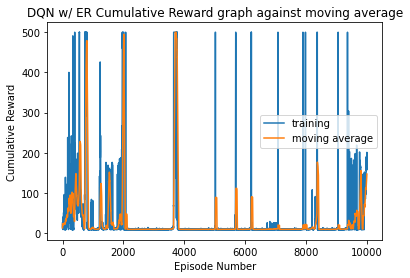

In [10]:
array = cum_rew_train
aver = moving_average(array, 50)

import matplotlib.pyplot as plt
fig = plt.gcf()
plt.title("DQN w/ ER Cumulative Reward graph against moving average")
plt.plot(array, label='training')
plt.plot(aver, label='moving average')
plt.xlabel("Episode Number")
plt.ylabel("Cumulative Reward")
plt.legend()